## Data-Analyst-Agent - PoC
Here, we will create the Data-Analyst agent. Given a single relevant table, it's task will be to attempt to answer the user's question.

The data-analyst agent will have access to Python-shell to run commands and perform analysis to learn insights about the data w.r.t the user's question.

We will use `LangGraph` to build this custom tool-calling agent.

Some desired features of the Data-Analyst agent:
- It should be able to write Python queries
- It should be able to run Python queries
- It should be able to import relevant python libraries (like Pandas, Numpy, JSON, etc.) required to run the code.
- The analysis it does should not include any visualisation, only the written descriptive statistics are required (since the LLM will be able to see and understand textual output only)
- It should be able to handle any runtime errors faced during Python execution, and take corrective actions by re-writing the python-script and attempting to run it again
- The output generated after running the Python queries should be used to gradually build the context, over multiple calls to Python-execution tool (if required)
- Once the agent "thinks" it has enough context to answer the question, it should attempt to answer the question citing only the statistics from the table
- If there's no relevant context, the agent should cease running and reply with something like - "*this table does not contain enough relevant information to answer your question ...*"

Let's get started.

In [2]:
import os
import io
import sys
import json
import traceback
import regex as re
import pandas as pd
from pyjstat import pyjstat
from textwrap import dedent
from pyjstat import pyjstat
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from typing import Dict, List, Any, Literal, Annotated

from langgraph.types import Command
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage, BaseMessage, AIMessage, ToolMessage
from langgraph.prebuilt import InjectedState
from langchain_core.tools import tool, InjectedToolCallId

In [3]:
from pathlib import Path
import os

root = Path().absolute().parents[1]
os.chdir(str(root))

In [4]:
llm_low = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-lite",
    temperature=1,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)
llm_med = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=1,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)
llm_high  = ChatGoogleGenerativeAI(
    model="gemini-2.5-pro",
    temperature=1,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

In [5]:
def _run_python_safely(code: str) -> Dict[str, Any]:
    """
    Minimal sandbox runner. In production: isolate with subprocess, container, time & mem limits.
    Returns {"stdout": str, "error": {"type":, "message":, "trace":}} on failure.
    """
    stdout_capture = io.StringIO()
    old_stdout, old_stderr = sys.stdout, sys.stderr
    sys.stdout = stdout_capture
    sys.stderr = stdout_capture  # co-mingle
    globals_dict = {"__name__": "__main__"}
    try:
        exec(code, globals_dict, globals_dict)
        out = stdout_capture.getvalue()
        return {"stdout": out}
    except Exception as e:
        err = {"type": e.__class__.__name__, "message": str(e), "trace": traceback.format_exc()}
        return {"stdout": stdout_capture.getvalue(), "error": err}
    finally:
        sys.stdout, sys.stderr = old_stdout, old_stderr

@tool(name_or_callable="python_code_executor", parse_docstring=True)
def python_code_executor(
    code: str,
    description: str,
    state: Annotated[dict, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
) -> str:
    """
    Executes the given Python code and returns the output.
    
    Args:
        code (str): The Python code to execute.
        description (str): A short description of the code being executed.
    
    Returns:
        str: The output of the executed code.
    """
    print("Executing code in python_code_executor: ", description)
    result = _run_python_safely(code)
    print("Result from python_code_executor: ", result['stdout'])

    if 'error' in result:
        return Command(
            update={
                "scratchpad": [
                    ToolMessage(
                        content=f"Error executing code: {result['error']}",
                        tool_call_id=tool_call_id,
                        name="python_code_executor"
                    )
                ],
            }
        )
    

    return Command(
        update={
            "scratchpad": [
                ToolMessage(
                    content=result['stdout'],
                    # content="Context updated with required analysis.",
                    tool_call_id=tool_call_id,
                    name="python_code_executor"
                )
            ],
        }
    )

TOOLS = [python_code_executor]

llm_med_with_code_exec_tool = llm_med.bind_tools(TOOLS, allowed_function_names=["python_code_executor"])
llm_high_with_code_exec_tool = llm_high.bind_tools(TOOLS, allowed_function_names=["python_code_executor"])

In [6]:
class State(TypedDict):
    """State for the analyst agent."""
    scratchpad: Annotated[list[BaseMessage], add_messages] = Field(default=[], description="The scratchpad for the agent.")
    context: str = Field(default=None, description="The context for the agent to use.")
    iters: int = Field(default=0, description="The number of iterations the agent has gone through.")
    sub_question: str = Field(description="The question asked by the user.")
    table_id: str = Field(description="The ID of the table being queried.")
    # csv_fp: str = Field(default="", description="The file path to the CSV file containing the CSO data.")
    # code: str = Field(default="", description="The python code to run.")


In [7]:
from src.helpers.json_stat_archive_db import JSONStatArchiveDB

cso_archive_reader = JSONStatArchiveDB(compression_level=12)

In [8]:
SYSTEM_PROMPT_ANALYST = dedent(
    f"""\
        # ROLE: I am a Data Analyst Agent that has access to Python-shell tool/function - `python_code_executor(code: str, description: str)`.

        # INSTRUCTIONS:
            - I call the `python_code_executor` tool to analyse the data.
            - Once I feel I know enough, I give a crisp and concise answer to the user's question.

        # NOTE:
            - The python-script should import necessary libraries (pandas, numpy, os, pathlib, etc) to read the CSV file and perform data manipulation 
            - The python-script use `print` statements for printing any statistics that you need to fetch.
            - In a single tool-call to `python_code_executor`, I ask for a single statistic to be fetched.
            - I keep the commentary limited in this step.
            - Once I have enough statistics to answer the user's question, I give a crisp and concise answer to user's question, with proper data backing it up.
        
        # WARNINGS:
            - For tool-calls to `python_code_executor` tool, only send the python code as `code` parameter
            - Do not include any visualizations or plots in the code.
            - In case I get reported back with any errors in executing the python code, I should make necessary corrections and call the python_code_executor tool to re-run the code.
        
        # TIPS:
            - For high cardinality columns, consider using simple keyword based filtering (like `str.contains('abc|xyz')`). Also consider items / categories related to said keywords.
    """
)
def _create_table_analysis(df: pd.DataFrame, table_id: str) -> dict:
    """
    Analyzes the table and returns a dictionary with the analysis results.

    Args:
        df (pd.DataFrame): The DataFrame containing the CSO data.

    Returns:
        dict: A dictionary containing the analysis results.
    """
    csv_fp = f"cache/{table_id}.csv"
    try:
        table_shape = df.shape
        table_sample = pd.concat([df.head(5), df.tail(5)]) if len(df) > 10 else df
        
        table_info_df = pd.DataFrame({
            "columns": df.columns,
            "dtypes": [str(df[col].dtype) for col in df.columns],
            "nunique": [df[col].nunique() if df[col].nunique() <= 50 else '>50' for col in df.columns],
            "nulls": [df[col].isnull().sum() for col in df.columns]
        })

        context_list = [
            "CONTEXT:",
            f"- **CSV File Path**: {csv_fp}",
            f"- **Table Shape**: {table_shape}",
            "- **Table Info**:",
            table_info_df.to_string(index=False),
            "- **Table Sample (first and last 5 rows)**:",
            table_sample.to_string(index=False),
        ]

    except Exception as e:
        context_list = None

    return context_list

def analyst_agent(state: State) -> str:
    """
    The analyst agent has access to the Python-Shell tool and uses it answer the user query by analysing the data available in context.

    Args:
        state (State): The state containing the messages and other data.
    
    Returns:
        str: The response from the analyst agent.
    """
    sub_question = state["sub_question"]
    old_messages = state["scratchpad"]
    system_prompt = SYSTEM_PROMPT_ANALYST
    iters = state.get("iters", 0)
    table_id = state["table_id"]
    iters += 1

    csv_save_dir = "cache/"
    csv_fp = csv_save_dir + f"{table_id}.csv"

    # check if "<table_id>.csv" exists. If not, read the pyjstat-file from artifacts and save the DataFrame as "<table_id>.csv"
    if not os.path.exists(csv_fp):
        for _, ds, _ in cso_archive_reader.read("artifacts/cso_bkp/cso_archive/jsonstat_archive.sqlite", table_id=table_id, with_labels=True):
            df: pd.DataFrame = pyjstat.from_json_stat(ds)[0]
        df.to_csv(csv_fp, index=False)

    if state.get("context", None) is None:
        df = pd.read_csv(csv_fp)
        context_list = _create_table_analysis(df, table_id)
        context = "\n".join(context_list) if context_list else "No context available."
    else:
        context = state["context"]

    msgs = [
        SystemMessage(content=system_prompt, name="analyst_agent"),
        SystemMessage(content=context, name="analyst_agent"),
        HumanMessage(content=sub_question, name="analyst_agent"),
    ] + old_messages
    
    if iters <= 10:
        print("Running data-analyst agent...")
        res = llm_med_with_code_exec_tool.invoke(msgs)
    else:
        print("Stopping tool-calls as max-iterations reached. Generating final response...")
        res = llm_med.invoke(msgs)
        return {"scratchpad": [res], "iters": iters, "context": context}
    
    if isinstance(res, AIMessage):
        return {"scratchpad": [res], "iters": iters, "context": context}
    else:
        res = AIMessage("Error generating code.")
        return {"scratchpad": [res], "iters": iters, "context": context}


In [9]:
def has_tool_calls(msg: AIMessage) -> bool:
    """
    Check if the AIMessage has tool calls.
    
    Args:
        msg (AIMessage): The AI message to check.
    
    Returns:
        bool: True if the message has tool calls, False otherwise.
    """
    return getattr(msg, "tool_calls", None) is not None or \
           bool(getattr(msg, "additional_kwargs", {}).get("function_call") or \
                getattr(msg, "additional_kwargs", {}).get("tool_calls"))


def custom_tools_condition(state: State) -> bool:
    """
    Route the LLM based on tool calls in the last message.
    
    Args:
        state (State): The current state of the graph.
    
    Returns:
        str: "tools" if the last message has tool calls, "end" otherwise.
    """
    messages_key = "scratchpad"
    if isinstance(state, list):
        ai_message = state[-1]
    elif isinstance(state, dict) and (messages := state.get(messages_key, [])):
        ai_message = messages[-1]
    elif messages := getattr(state, messages_key, []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"

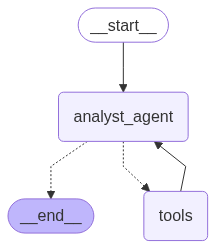

In [10]:
tool_node = ToolNode(TOOLS, messages_key="scratchpad")

analyst_graph_builder = StateGraph(State)

analyst_graph_builder.add_node("analyst_agent", analyst_agent)
analyst_graph_builder.add_node("tools", tool_node)

analyst_graph_builder.add_edge(START, "analyst_agent")
analyst_graph_builder.add_conditional_edges("analyst_agent", custom_tools_condition, {"__end__": END, "tools": "tools"})
# analyst_graph_builder.add_conditional_edges("analyst_agent", custom_tools_condition, {"end": END, "tools": "tools"})
analyst_graph_builder.add_edge("tools", "analyst_agent")

analyst_graph = analyst_graph_builder.compile()
analyst_graph

In [11]:
question = "QUESTION: Give me the breakdown of renewable energy resources as a percentage share and absolute numbers in 2022 in ireland."
question = "QUESTION: How's the energy production in ireland over the years? Do a detailed comparison of renewable vs non-renewable share of energy"
# question = "QUESTION: How's the wind energy production over the years?"
question = "QUESTION: Did the Ukraine war have any impact on the energy production in ireland??"
# question = "QUESTION: How has nuclear energy done over the years in ireland?"
# question = "QUESTION: What's the impact of climate change on energy production in ireland?"
# question = "QUESTION: How's the energy production in ireland over 2021-2025? Do a detailed comparison of renewable vs non-renewable share of energy"
# question = "QUESTION: What's the total agricultural area in Ireland?"
question = "detailed statistics on cosmetics, toileteries and related items production in prodcom data for ireland"
# question = "detailed statistics on lignin based products and related items production in prodcom data for ireland"



table_id = "PCA23"

res = analyst_graph.invoke(
    {
        "sub_question": question,
        "table_id": table_id,
    },
    # config={"recursion_limit": 1}
)
print("\n\nFINAL OUTPUT:\n", res["scratchpad"][-1].content)

Running data-analyst agent...
Executing code in python_code_executor:  Calculate the total production value for cosmetics, toiletries, and related items in Prodcom Sales 2023 data.
Result from python_code_executor:  Total production value for cosmetics, toiletries and related items: 20519.0

Running data-analyst agent...


FINAL OUTPUT:
 The total production value for cosmetics, toiletries, and related items in Prodcom Sales 2023 data for Ireland is 20519.0.


In [12]:
res

{'scratchpad': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'python_code_executor', 'arguments': '{"code": "\\nimport pandas as pd\\n\\ndf = pd.read_csv(\\"cache/PCA23.csv\\")\\n\\n# Filter for Prodcom Sales 2023\\ndf_prodcom_sales = df[df[\\"Statistic\\"] == \\"Prodcom Sales 2023\\"]\\n\\n# Filter for cosmetics, toiletries and related items\\ncosmetics_toiletries_df = df_prodcom_sales[df_prodcom_sales[\\"Product\\"].str.contains(\\"cosmetic|toilet|perfume|soap|shampoo|dentifrice|make-up|fragrance\\", case=False, na=False)]\\n\\n# Replace -99999999.0 with NaN and sum the values\\ncosmetics_toiletries_df = cosmetics_toiletries_df.replace(-99999999.0, pd.NA)\\ntotal_production_value = cosmetics_toiletries_df[\\"value\\"].sum()\\n\\nprint(f\\"Total production value for cosmetics, toiletries and related items: {total_production_value}\\")\\n", "description": "Calculate the total production value for cosmetics, toiletries, and related items in Prodcom Sales 2023 data.

In [13]:
res["scratchpad"]

[AIMessage(content='', additional_kwargs={'function_call': {'name': 'python_code_executor', 'arguments': '{"code": "\\nimport pandas as pd\\n\\ndf = pd.read_csv(\\"cache/PCA23.csv\\")\\n\\n# Filter for Prodcom Sales 2023\\ndf_prodcom_sales = df[df[\\"Statistic\\"] == \\"Prodcom Sales 2023\\"]\\n\\n# Filter for cosmetics, toiletries and related items\\ncosmetics_toiletries_df = df_prodcom_sales[df_prodcom_sales[\\"Product\\"].str.contains(\\"cosmetic|toilet|perfume|soap|shampoo|dentifrice|make-up|fragrance\\", case=False, na=False)]\\n\\n# Replace -99999999.0 with NaN and sum the values\\ncosmetics_toiletries_df = cosmetics_toiletries_df.replace(-99999999.0, pd.NA)\\ntotal_production_value = cosmetics_toiletries_df[\\"value\\"].sum()\\n\\nprint(f\\"Total production value for cosmetics, toiletries and related items: {total_production_value}\\")\\n", "description": "Calculate the total production value for cosmetics, toiletries, and related items in Prodcom Sales 2023 data."}'}}, response

In [15]:
res["scratchpad"][0].tool_calls

[{'name': 'python_code_executor',
  'args': {'code': '\nimport pandas as pd\n\ndf = pd.read_csv("cache/PCA23.csv")\n\n# Filter for Prodcom Sales 2023\ndf_prodcom_sales = df[df["Statistic"] == "Prodcom Sales 2023"]\n\n# Filter for cosmetics, toiletries and related items\ncosmetics_toiletries_df = df_prodcom_sales[df_prodcom_sales["Product"].str.contains("cosmetic|toilet|perfume|soap|shampoo|dentifrice|make-up|fragrance", case=False, na=False)]\n\n# Replace -99999999.0 with NaN and sum the values\ncosmetics_toiletries_df = cosmetics_toiletries_df.replace(-99999999.0, pd.NA)\ntotal_production_value = cosmetics_toiletries_df["value"].sum()\n\nprint(f"Total production value for cosmetics, toiletries and related items: {total_production_value}")\n',
   'description': 'Calculate the total production value for cosmetics, toiletries, and related items in Prodcom Sales 2023 data.'},
  'id': '31e0220b-cf6a-454b-9e43-3b0d5cb59848',
  'type': 'tool_call'}]

In [16]:
res["scratchpad"][0].model_dump()

{'content': '',
 'additional_kwargs': {'function_call': {'name': 'python_code_executor',
   'arguments': '{"code": "\\nimport pandas as pd\\n\\ndf = pd.read_csv(\\"cache/PCA23.csv\\")\\n\\n# Filter for Prodcom Sales 2023\\ndf_prodcom_sales = df[df[\\"Statistic\\"] == \\"Prodcom Sales 2023\\"]\\n\\n# Filter for cosmetics, toiletries and related items\\ncosmetics_toiletries_df = df_prodcom_sales[df_prodcom_sales[\\"Product\\"].str.contains(\\"cosmetic|toilet|perfume|soap|shampoo|dentifrice|make-up|fragrance\\", case=False, na=False)]\\n\\n# Replace -99999999.0 with NaN and sum the values\\ncosmetics_toiletries_df = cosmetics_toiletries_df.replace(-99999999.0, pd.NA)\\ntotal_production_value = cosmetics_toiletries_df[\\"value\\"].sum()\\n\\nprint(f\\"Total production value for cosmetics, toiletries and related items: {total_production_value}\\")\\n", "description": "Calculate the total production value for cosmetics, toiletries, and related items in Prodcom Sales 2023 data."}'}},
 'respon

In [22]:
res["scratchpad"][1].model_dump()

{'content': 'Total production value for cosmetics, toiletries and related items: 20519.0\n',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'tool',
 'name': 'python_code_executor',
 'id': '931a6db0-3a81-4f5a-871a-d844c51b0894',
 'tool_call_id': '31e0220b-cf6a-454b-9e43-3b0d5cb59848',
 'artifact': None,
 'status': 'success'}

In [20]:
from langchain_core.messages import AIMessage

# Example: create a tool-call for your tool
tool_call = {
    "name": "python_code_executor",
    "args": {
        "code": "print('Hello, world!')",
        "description": "Print hello world"
    },
    "id": "my_tool_call_id_1"  # unique ID for this call
}

# Create an AIMessage with tool_calls
ai_msg = AIMessage(
    content="I need to run some code to answer your question.",
    tool_calls=[tool_call]
)

In [21]:
ai_msg.model_dump()

{'content': 'I need to run some code to answer your question.',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'ai',
 'name': None,
 'id': None,
 'example': False,
 'tool_calls': [{'name': 'python_code_executor',
   'args': {'code': "print('Hello, world!')",
    'description': 'Print hello world'},
   'id': 'my_tool_call_id_1',
   'type': 'tool_call'}],
 'invalid_tool_calls': [],
 'usage_metadata': None}

In [25]:
q = 'Based on the information available:\n\n*   The total agricultural area in Ireland is **53,543.683 hectares** (Source: AQA06).\n*   Another source indicates the total agricultural area in Ireland is **416,415.0 hectares** (Source: AVA33).\n*   Furthermore, the total agricultural area in Ireland was **4,509,256.2 hectares in 2020** and **4,620,095.9 hectares in 2023** (Source: IFS10).\n\nThere are discrepancies in the reported total agricultural area across different sources.'
print(q)

Based on the information available:

*   The total agricultural area in Ireland is **53,543.683 hectares** (Source: AQA06).
*   Another source indicates the total agricultural area in Ireland is **416,415.0 hectares** (Source: AVA33).
*   Furthermore, the total agricultural area in Ireland was **4,509,256.2 hectares in 2020** and **4,620,095.9 hectares in 2023** (Source: IFS10).

There are discrepancies in the reported total agricultural area across different sources.
